# Python: Types & bit-depths

In this section, we will explore how bit-depths and image types are represented in Python.
We'll look in particular at where things can go wrong when converting between bit-depths, and how to apply the tricks from previous chapters to identify problems.

In [1]:
# First, our usual default imports
import sys
sys.path.append('../../../')

from helpers import *
import matplotlib.pyplot as plt
import numpy as np

## Bit-depths and dtype

The bit-depth of a **NumPy array** is encoded in its **data type** - or **dtype** for short.

ImageJ is focussed on on 8-bit and 16-bit unsigned integer images, as well as 32-bit floating point images.

NumPy, on the other hand, offers a much wider range of data types.
The code for a Numpy dtype isn't hard to crack, with a `uint` standing for 'unsigned integer' and `float` for floating-point.

| Type             | Bit-depth | dtype     |
| ---------------- | --------- | --------- |
| Unsigned integer | 8         | `uint8`   |
| Signed integer   | 8         | `int8`    |
| Unsigned integer | 16        | `uint16`  |
| Signed integer   | 16        | `int16`   |
| Unsigned integer | 32        | `uint32`  |
| Signed integer   | 32        | `int32`   |
| Floating point   | 32        | `float32` |
| Floating point   | 64        | `float64` |

The `dtype` for any array is easy to check:

In [2]:
im = load_image('sunny_cell.tif')

print(im.dtype)

uint16


We can print some basic statistics, as before.
In particular, we can check that the minimum and maximum values fall inside the expected range.

Mean: 527.56
Minimum: 239
Maximum: 2090


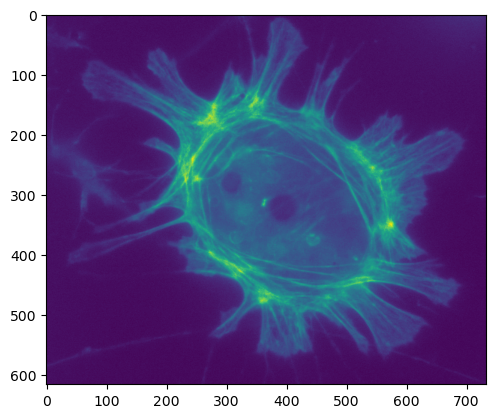

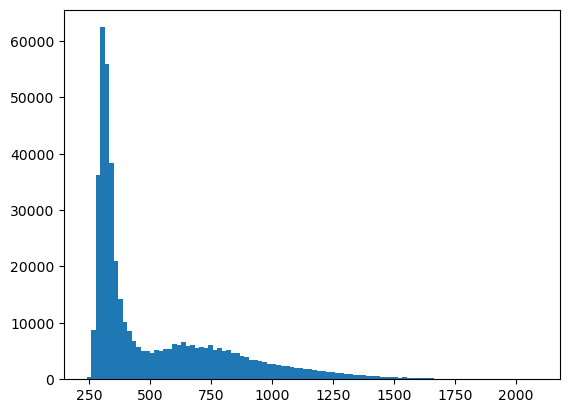

In [3]:
print(f'Mean: {im.mean():.2f}')
print(f'Minimum: {im.min()}')
print(f'Maximum: {im.max()}')

plt.imshow(im)
plt.show()

plt.hist(im.flatten(), bins=100)
plt.show()

### Fun with float32

If we want to change the type, that is easy to do as well.

> This makes use of the line `import numpy as np` to give us access to more NumPy properties & functions.

In [4]:
im_float = im.astype(np.float32)

This should convert our image into 32-bit floating point.

However, when trying out a new command it is always a good idea to check it does what was expected.
We can do that by showing the image and printing statistics again.

Mean:    527.56
Minimum: 239.0
Maximum: 2090.0


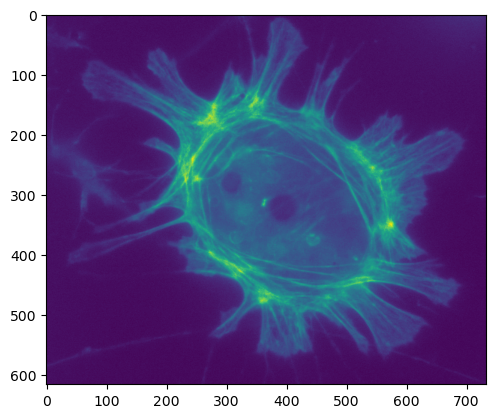

In [5]:
print(f'Mean:    {im_float.mean():.2f}')
print(f'Minimum: {im_float.min()}')
print(f'Maximum: {im_float.max()}')

plt.imshow(im_float)
plt.show()

That looks fine to me, but let's be extra careful and have NumPy check if the values are really identical.

One way we might do that is with `==`.

In [6]:
print(im == im_float)

[[ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 ...
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]]


Hmmm, that looks quite convincing - it gives us an image that has either `True` or `False` for every single pixel.
But because of the limits of what is printing, it really only shows that the pixels at the corners of our image match.

If we want to ensure that *all* pixels are the same, we can use `np.all`

In [7]:
print(np.all(im == im_float))

True


**Success!**

But... skepticism belongs in science - particularly in image analysis - and it's always worth testing things from multiple angles, just in case.
So let's check the statistics as well:

In [8]:
if im.min() == im_float.min():
    print('Minimum values are identical!')
else:
    print('Minimum values are different...')
    
if im.max() == im_float.max():
    print('Maximum values are identical!')
else:
    print('Maximum values are different...')

if im.mean() == im_float.mean():
    print('Mean values are identical!')
else:
    print('Mean values are different...')

Minimum values are identical!
Maximum values are identical!
Mean values are different...


Uh-oh... that was unexpected.

**Somehow, we have two images with exactly the same pixel values - and yet they have a different mean value??!**

It doesn't seem to make sense.
We need to investigate by printing the actual values:

In [9]:
print(f'Mean values are different... {im.mean()} vs {im_float.mean()}')

Mean values are different... 527.5647778210875 vs 527.5647583007812


Ok, so the means are actually very very close - and we need to go a long way after the decimal point before there is a difference.

This is an example of a **precision error**.

Precisions errors are common when coding, and we need to always be on our guard against them.
They can occur in the midst of calculations because intermediate results aren't stored with perfect precision, but rather rounded to a value that is close.

This happens both with integer and floating-point types - but of course it is more severe when working with integers.
As an illustration using decimal values (since it's harder for most of us to think in binary), let's consider dividing a number by 3 and then multiplying the result by 3.
Mathematically, we *should* get the same result.

However, if we do our calculations using only with integers we instead see

$$
\begin{align}
\frac{10}{3}  & \approx 3 \\
\\
3 \times 3  & = 9
\end{align}
$$

On the other hand, if we use floating point (to three decimal places for illustration) we would get

$$
\begin{align}
\frac{10}{3} & \approx 3.333 \\
\\
3.333 \times 3 & = 9.999
\end{align}
$$

*Neither* gives the mathematically 'correct' final result of 10, because of the precision errors.

Consequently, rather than checking whether non-integer values are identical with one another by using `==`, we often need to check if they are very close to one another.
We can use `np.allclose` for that.

In [10]:
np.allclose(im.mean(), im_float.mean())

True

### Towards 8-bit

Previously, we had an image with a low bit depth and we increased the bit-depth.
This was fine.

Time now to go the opposite direction, and again check that it works.

Mean:    96.25
Minimum: 0
Maximum: 255


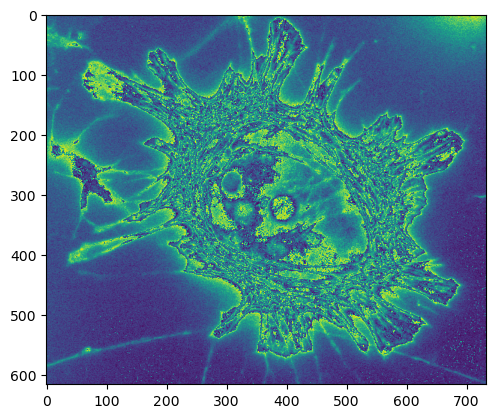

In [11]:
im_u8 = im.astype(np.uint8)

print(f'Mean:    {im_u8.mean():.2f}')
print(f'Minimum: {im_u8.min()}')
print(f'Maximum: {im_u8.max()}')

plt.imshow(im_u8)
plt.show()

Oh dear.
This is categorically **not** all right.

Our minimum and maximum values are in the range 0-255 - which is all that's permitted in an unsigned integer, 8-bit image, so that makes sense.
But the appearance doesn't make much sense at first look.

Whenever we reduce the bit-depth of an image, we know that the pixel values will need to fit into the new range.
In the main text, we considered two ways that could happen: by clipping or by rescaling.

Here, we are meeting a slight idiosyncracy of NumPy that we really need to be careful about: *by default, it will neither clip nor rescale!*

But what *does* it do?
Rather than googling or crawling around the NumPy docs, we can experiment.

In [12]:
# Create an array from 0-1000 (in increments of 100)
a = np.arange(0, 1001, 100)
print(a.dtype)
print(a)

int64
[   0  100  200  300  400  500  600  700  800  900 1000]


In [13]:
# Convert to uint8 and see what happens
b = a.astype(np.uint8)
print(b.dtype)
print(b)

uint8
[  0 100 200  44 144 244  88 188  32 132 232]


In [14]:
# Just to make things clearer
# print the original values above and the new values below
print(np.vstack([a, b]))

[[   0  100  200  300  400  500  600  700  800  900 1000]
 [   0  100  200   44  144  244   88  188   32  132  232]]


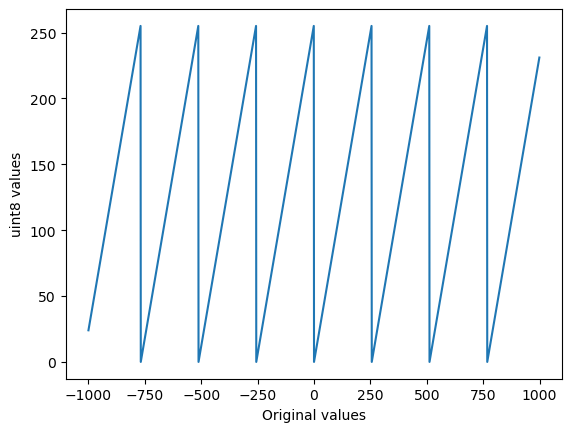

In [15]:
# And, once more, lets plot lots of values against their converted-to-uint8 versions
plt.plot(np.arange(-1000, 1000), np.arange(-1000, 1000).astype(np.uint8))
plt.xlabel('Original values')
plt.ylabel('uint8 values')
plt.show()

So it seems that NumPy *wraps around*: when converting 256 to `uint8` it becomes 0, 257 becomes 1 and so on.

This means that, to convert an image to `uint8`, we need to take matters into our own hands to reduce data loss.
To begin, let's clip.

### Converting with clipping

The trick is to clip the image this *before* converting it with `astype`:

uint8
Mean:    255.00
Minimum: 239
Maximum: 255


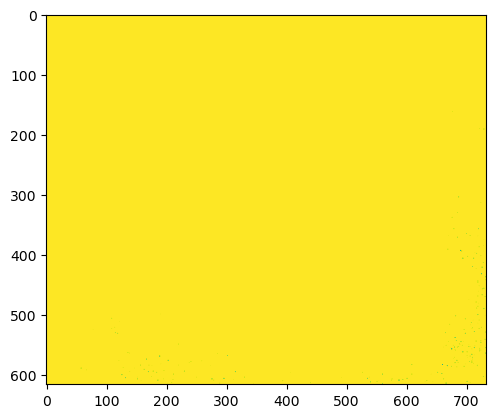

In [16]:
im_u8_clipped = np.clip(im, 0, 255).astype(np.uint8)

print(im_u8_clipped.dtype)
print(f'Mean:    {im_u8_clipped.mean():.2f}')
print(f'Minimum: {im_u8_clipped.min()}')
print(f'Maximum: {im_u8_clipped.max()}')

plt.imshow(im_u8_clipped)
plt.show()

This has worked in a sense, but not a very good one.
Our pixels are in the range 0-255, but recall from the histogram above that almost all the pixels were originally above 255 in value.
When we clipped, these pixels all simply became 255 - and all further distinction was lost.

### Converting with rescaling

We can calculate the maximum possible value of an unsigned integer for a specific bit depth $N$ as $2^{N}-1$.

With Numpy, we can use the `**` operator for this.

In [17]:
max_u8 = 2**8 - 1
print(f'Maximum value for 8-bit unsigned integer: {max_u8}')

max_u16 = 2**16 - 1
print(f'Maximum value for 16-bit unsigned integer: {max_u16}')

Maximum value for 8-bit unsigned integer: 255
Maximum value for 16-bit unsigned integer: 65535


Therefore, to convert our 16-bit image to 8-bit by rescaling, we could multiply the pixel values by the ratio of these maximum values, i.e. by $\frac{255}{65535}$

uint8
Mean:    1.68
Minimum: 0
Maximum: 8


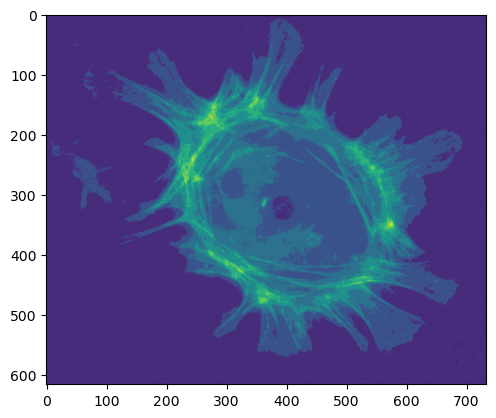

In [18]:
im_uint8_scaled = im * (255 / 65535)
im_uint8_scaled = im_uint8_scaled.astype(np.uint8)

print(im_uint8_scaled.dtype)
print(f'Mean:    {im_uint8_scaled.mean():.2f}')
print(f'Minimum: {im_uint8_scaled.min()}')
print(f'Maximum: {im_uint8_scaled.max()}')

plt.imshow(im_uint8_scaled)
plt.show()

This has *kind of* worked, but note that the maximum pixel value is very low.
We have lost a *lot* of information: squeezing our values into a very small range of integers, much less than the full 256 available to us.

Ideally, we would usually like to rescale our image while preserving as much of the information as possible.
We would like the values in our output image to fill the full range of 0-255.

We can do this in five steps:
1. Convert the image to floating point (so that we don't lose info to rounding)
2. Subtract the minimum value, so that the minimum becomes zero
3. Divide by the new maximum value, so that the maximum becomes one
4. Multiply by 255
5. Convert to 8-bit

uint8
Mean:    39.25
Minimum: 0
Maximum: 255


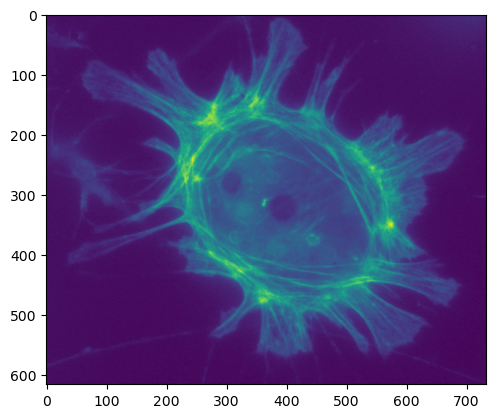

In [19]:
im_temp = im - im.min()
im_temp = im_temp / im_temp.max()
im_temp = im_temp * 255

im_uint8_scaled = im_temp.astype(np.uint8)

print(im_uint8_scaled.dtype)
print(f'Mean:    {im_uint8_scaled.mean():.2f}')
print(f'Minimum: {im_uint8_scaled.min()}')
print(f'Maximum: {im_uint8_scaled.max()}')

plt.imshow(im_uint8_scaled)
plt.show()

As conversions to 8-bit go, rescaling certainly looks like it was more successful than simply clipping, and the output fills the full range available.

Nevertheless, **don't forget that the statistics are different, and we have changed the pixel values!**

Therefore this isn't something we should do without a very good reason.

## Summary

**The key message here is that it is very easy to change the bit-depth and type of an image - but also very easy for things to go wrong.**

Sometimes these are small precision errors.
Sometimes they are big, data, destroying errors.

But if you know how to show images, make measurements and generate histograms, you can always check what is happening to the data at each step.
This can help you make sure nothing is being lost along the way.